In [2]:
# Chrome WebDriver 설정
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

# 페이지 열기
url = "https://charts.youtube.com/charts/TopSongs/kr/weekly/20241226"
driver.get(url)

# 페이지 로드 대기
time.sleep(3)

# 페이지 소스 가져오기
soup = BeautifulSoup(driver.page_source, 'html.parser')

# 해당 클래스의 div 태그 찾기
div_tag = soup.find('div', class_='ytmc-chart-table-v2-container')

print(div_tag)

<div class="ytmc-chart-table-v2-container style-scope ytmc-detailed-page">
<ytmc-chart-table-v2 class="style-scope ytmc-detailed-page"><!--css_build_mark:video.youtube.src.web.polymer.music_charts.components.ui.ytmc_chart_table_v2.ytmc.chart.table.v2.css.js--><!--css_build_scope:ytmc-chart-table-v2--><!--css_build_styles:video.youtube.src.web.polymer.music.app.ui.shared.styles.ytmusic_base_styles.ytmusic.base.styles.css.js,video.youtube.src.web.polymer.shared.ui.styles.yt_base_styles.yt.base.styles.css.js,video.youtube.src.web.polymer.music_charts.components.ui.ytmc_chart_table_v2.ytmc.chart.table.v2.css.js--><div class="chart-table-container style-scope ytmc-chart-table-v2">
<div class="content table-header style-scope ytmc-chart-table-v2">
<span class="table-header-rank style-scope ytmc-chart-table-v2">순위</span>
<div class="table-header-thumbnail style-scope ytmc-chart-table-v2"></div>
<span class="table-header-metric style-scope ytmc-chart-table-v2" hidden="">
      발매일
    </span>


In [255]:
tag = div_tag.find('div', {'class':'chart-table-container'})
tag

<div class="chart-table-container style-scope ytmc-chart-table-v2">
<div class="content table-header style-scope ytmc-chart-table-v2">
<span class="table-header-rank style-scope ytmc-chart-table-v2">순위</span>
<div class="table-header-thumbnail style-scope ytmc-chart-table-v2"></div>
<span class="table-header-metric style-scope ytmc-chart-table-v2" hidden="">
      발매일
    </span>
<span class="table-header-metric style-scope ytmc-chart-table-v2" id="last-period">
      지난주
    </span>
<span class="table-header-metric tablet-non-displayed-metric style-scope ytmc-chart-table-v2" id="periods-on-chart">
      차트 지속기간(주)
    </span>
<span class="table-header-metric tablet-non-displayed-metric style-scope ytmc-chart-table-v2" id="views">
      주간 조회수
    </span>
</div>
<ytmc-entry-row class="style-scope ytmc-chart-table-v2"><!--css_build_mark:video.youtube.src.web.polymer.music_charts.components.ui.ytmc_entry_row.ytmc.entry.row.css.js--><!--css_build_scope:ytmc-entry-row--><!--css_build_style

In [256]:
#rank(1~100) list
rank = tag.find_all('span', {'id':'rank'})
rank_list = []

for i in range(len(rank)):
    rank_list.append(rank[i].text)

#title list
title = tag.find_all('div', {'id':'entity-title'})
title_list = []

for i in range(len(title)):
    title_list.append(title[i].text.strip())

# artist list
artist = tag.find_all('div', {'id': 'artist-names'})
artist_list = []

for i in range(len(artist)):
    artist_spans = artist[i].find_all('span', {'hidden': False})    #hidden 속성 X => text 반복 제외
    artist_name = " ".join([span.text.strip() for span in artist_spans])    #strip()으로 분리하고 join()으로 하나로 합치기 => ex. "로제 & 브루노마스" 분리 방지
    artist_list.append(artist_name)

#[발매일, 지난주 순위]
releaseNlast_week = tag.find_all('div', {'class':'metric content center style-scope ytmc-entry-row'}, {'hidden':False})
release_list = []
last_week_list = []

for i in range(len(releaseNlast_week)):    
    #발매일
    if i % 2 == 0:
        release_list.append(releaseNlast_week[i].text.strip())
    #지난주 순위
    else:
        last_week_list.append(releaseNlast_week[i].text.strip())

#지난주 순위랑 같을 경우('-') → 0
for i in range(len(last_week_list)):
    if last_week_list[i] == '-':
        last_week_list[i] = '0'

#[차트 지속기간(주), 주간 조회수]
durationNplay = tag.find_all('div', {'class':'metric content center tablet-non-displayed-metric style-scope ytmc-entry-row'}, {'hidden':False})
duration_list = []
play_list = []

for i in range(len(durationNplay)):
    #차트 지속기간(주)
    if i % 2 == 0:
        duration_list.append(durationNplay[i].text.strip())
    else:
        play_list.append(durationNplay[i].text.strip().replace(',', ''))    #4,582,686 → 4582686

In [257]:
data = {
    '순위':rank_list,
    '제목':title_list,
    '가수':artist_list,
    '발매일':release_list,
    '지난주':last_week_list,
    '지속기간':duration_list,
    '조회수':play_list
}

df = pd.DataFrame(data)
df[['순위', '지난주', '지속기간', '조회수']] = df[['순위', '지난주', '지속기간', '조회수']].astype('int')
df['발매일'] = pd.to_datetime(df['발매일'], format='%b %d, %Y')

df.head()

,순위,제목,가수,발매일,지난주,지속기간,조회수
0,1,APT.,로제 & 브루노 마스,2024-10-18,1,10,4582686
1,2,HOME SWEET HOME (feat. 태양 & 대성),G-DRAGON,2024-11-22,2,5,3993657
2,3,Whiplash,aespa,2024-10-21,3,10,3476261
3,4,toxic till the end,로제,2024-12-05,4,3,2888778
4,5,Drowning (Live),WOODZ,2023-04-26,6,13,2313519


In [258]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   순위      100 non-null    int32         
 1   제목      100 non-null    object        
 2   가수      100 non-null    object        
 3   발매일     100 non-null    datetime64[ns]
 4   지난주     100 non-null    int32         
 5   지속기간    100 non-null    int32         
 6   조회수     100 non-null    int32         
dtypes: datetime64[ns](1), int32(4), object(2)
memory usage: 4.0+ KB


----

In [250]:
# 2024년, 1주차부터 52주차까지 크롤링
start_date = datetime(2024, 1, 4)  # 시작 날짜

for week in range(1, 53):
    week_date = start_date + timedelta(weeks=week-1)
    url = "https://charts.youtube.com/charts/TopSongs/kr/weekly/{}{:02d}{:02d}".format(week_date.year, week_date.month, week_date.day)
    print(url)

https://charts.youtube.com/charts/TopSongs/kr/weekly/20240104
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240111
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240118
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240125
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240201
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240208
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240215
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240222
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240229
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240307
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240314
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240321
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240328
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240404
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240411
https://charts.youtube.com/charts/TopSongs/kr/weekly/20240418
https://

---

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import requests
from re import escape
from bs4 import BeautifulSoup
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
from bs4 import BeautifulSoup
import time
from datetime import datetime, timedelta

plt.rcParams['font.family'] = 'Malgun Gothic'

# 2024년 1월 5일 ~ 12월 26일 주간 차트

In [2]:
# Chrome WebDriver 설정
options = webdriver.ChromeOptions()
driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=options)

df2024 = []
cnt = 0

start_date = datetime(2024, 1, 4)  # 시작 날짜

for week in range(1, 53):
    week_date = start_date + timedelta(weeks=week-1)
    url = "https://charts.youtube.com/charts/TopSongs/kr/weekly/{}{:02d}{:02d}".format(week_date.year, week_date.month, week_date.day)

    driver.get(url)

    # 페이지 로드 대기
    time.sleep(3)

    # 페이지 소스 가져오기
    soup = BeautifulSoup(driver.page_source, 'html.parser')

    div_tag = soup.find('div', class_='ytmc-chart-table-v2-container')  #여기까지는 출력됨
    tag = div_tag.find('div', {'class':'chart-table-container'})    #여기까지는 출력됐음

    #rank(1~100) list
    rank = tag.find_all('span', {'id':'rank'})
    rank_list = []

    for i in range(len(rank)):
        rank_list.append(rank[i].text)

    #title list
    title = tag.find_all('div', {'id':'entity-title'})
    title_list = []

    for i in range(len(title)):
        title_list.append(title[i].text.strip())

    # artist list
    artist = tag.find_all('div', {'id': 'artist-names'})
    artist_list = []

    for i in range(len(artist)):
        artist_spans = artist[i].find_all('span', {'hidden': False})    #hidden 속성 X => text 반복 제외
        artist_name = " ".join([span.text.strip() for span in artist_spans])    #strip()으로 분리하고 join()으로 하나로 합치기 => ex. "로제 & 브루노마스" 분리 방지
        artist_list.append(artist_name)

    #[발매일, 지난주 순위]
    releaseNlast_week = tag.find_all('div', {'class':'metric content center style-scope ytmc-entry-row'}, {'hidden':False})
    release_list = []
    last_week_list = []

    for i in range(len(releaseNlast_week)):    
        #발매일
        if i % 2 == 0:
            release_list.append(releaseNlast_week[i].text.strip())
        #지난주 순위
        else:
            last_week_list.append(releaseNlast_week[i].text.strip())

    #지난주 순위랑 같을 경우('-') → 0
    for i in range(len(last_week_list)):
        if last_week_list[i] == '-':
            last_week_list[i] = '0'

    #[차트 지속기간(주), 주간 조회수]
    durationNplay = tag.find_all('div', {'class':'metric content center tablet-non-displayed-metric style-scope ytmc-entry-row'}, {'hidden':False})
    duration_list = []
    play_list = []

    for i in range(len(durationNplay)):
        #차트 지속기간(주)
        if i % 2 == 0:
            duration_list.append(durationNplay[i].text.strip())
        else:
            play_list.append(durationNplay[i].text.strip().replace(',', ''))    #4,582,686 → 4582686
    
    #몇 주 차
    cnt += 1

    data = {
        '순위':rank_list,
        '제목':title_list,
        '가수':artist_list,
        '발매일':release_list,
        '지난주 순위':last_week_list,
        '차트 지속기간':duration_list,
        '조회수':play_list,
        '주차':cnt
    }

    df = pd.DataFrame(data)
    df[['순위', '지난주 순위', '차트 지속기간', '조회수', '주차']] = df[['순위', '지난주 순위', '차트 지속기간', '조회수', '주차']].astype('int')
    df['발매일'] = pd.to_datetime(df['발매일'], format='%b %d, %Y')

    df2024.append(df)

df2024 = pd.concat(df2024)
df2024.shape    #(5200, 7) => 100등 X 52주

(5200, 8)

In [3]:
df2024.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5200 entries, 0 to 99
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   순위       5200 non-null   int32         
 1   제목       5200 non-null   object        
 2   가수       5200 non-null   object        
 3   발매일      5200 non-null   datetime64[ns]
 4   지난주 순위   5200 non-null   int32         
 5   차트 지속기간  5200 non-null   int32         
 6   조회수      5200 non-null   int32         
 7   주차       5200 non-null   int32         
dtypes: datetime64[ns](1), int32(5), object(2)
memory usage: 264.1+ KB


In [5]:
df = df2024.copy()
df.head()

,순위,제목,가수,발매일,지난주 순위,차트 지속기간,조회수,주차
0,1,Perfect Night,르세라핌,2023-10-27,1,10,3670329,1
1,2,Drama,aespa,2023-11-08,2,8,3339128,1
2,3,디스코드,QWER,2023-10-18,3,12,2571909,1
3,4,To. X,태연,2023-11-27,5,6,2298120,1
4,5,Rhapsody of Sadness,임재현,2023-12-03,27,4,2296863,1


# 1. 아티스트
- 아티스트별 차트 진입 횟수
- 아티스트별 스트리밍 지속기간(주), 주간 조회수
- 아티스트의 곡별 차트

## (1) 아티스트

In [144]:
df.가수.value_counts().describe()

count    386.000000
mean      13.471503
std       24.232863
min        1.000000
25%        2.000000
50%        5.000000
75%       13.000000
max      185.000000
Name: count, dtype: float64

In [145]:
df.가수.value_counts().describe(percentiles=[0.7, 0.95, 0.98])

count    386.000000
mean      13.471503
std       24.232863
min        1.000000
50%        5.000000
70%       10.000000
95%       52.750000
98%      101.200000
max      185.000000
Name: count, dtype: float64

In [146]:
value_counts = df['가수'].value_counts()
q70 = value_counts.quantile(0.7)
q95 = value_counts.quantile(0.95)
q98 = value_counts.quantile(0.98)

# 각각의 값에 해당하는 가수 수
count_7 = (value_counts <= q70).sum()
count_95 = ((q70 < value_counts) & (value_counts <= q95)).sum() #Series 연산에서는 연산 부등식 X
count_98 = (q95 < value_counts).sum()

# 각 비율에 해당하는 가수들의 데이터프레임
df_q70 = df[df['가수'].isin(value_counts[value_counts <= q70].index)]
df_q95 = df[df['가수'].isin(value_counts[(q70 < value_counts) & (value_counts <= q95)].index)]
df_q98 = df[df['가수'].isin(value_counts[q98 < value_counts].index)]

In [121]:
len(df_q70.가수.value_counts()),len(df_q95.가수.value_counts()), len(df_q98.가수.value_counts())

(273, 93, 8)

### 상위 98% 이상

In [227]:
df_q98

,순위,제목,가수,발매일,지난주 순위,순위 지속기간,주간 조회수,주차
1,2,Drama,aespa,2023-11-08,2,8,3339128,1
2,3,디스코드,QWER,2023-10-18,3,12,2571909,1
9,10,에피소드,이무진,2023-12-13,11,3,2037673,1
13,14,I AM,IVE (아이브),2023-04-27,6,39,1723721,1
14,15,ETA,NewJeans,2023-07-21,18,23,1584302,1
...,...,...,...,...,...,...,...,...
5128,29,How Sweet,NewJeans,2024-05-24,27,31,960578,52
5132,33,Fate,(여자)아이들,2024-01-29,30,46,903227,52
5140,41,미리 메리 크리스마스 Merry Christmas ahead (feat. 천둥),아이유(IU),2010-12-09,51,35,798448,52
5150,51,청춘만화,이무진,2024-10-07,46,12,672415,52


#### 각 주별 1위곡

In [239]:
df_q28_week = df_q98.loc[df_q98.groupby('주차')['순위'].idxmin()]
df_q28_week.head()

,순위,제목,가수,발매일,지난주 순위,순위 지속기간,주간 조회수,주차
1,2,Drama,aespa,2023-11-08,2,8,3339128,1
101,2,Drama,aespa,2023-11-08,2,9,3127707,2
201,2,Drama,aespa,2023-11-08,2,10,2938224,3
300,1,Love wins all,아이유(IU),2024-01-23,0,1,3491444,4
400,1,Love wins all,아이유(IU),2024-01-23,1,2,5444618,5


**아티스트별 주차별 1위 횟수**

In [240]:
df_q28_week.가수.value_counts()

가수
aespa         22
NewJeans       9
(여자)아이들        7
아이유(IU)        6
QWER           4
DAY6(데이식스)     3
IVE (아이브)      1
Name: count, dtype: int64

In [241]:
df_q28_week.query("가수 =='NewJeans'")['제목'].unique()

array(['Bubble Gum', 'How Sweet', 'Supernatural'], dtype=object)

#### 아티스트별 차트 진입 횟수

In [147]:
df_q98.가수.value_counts()

가수
NewJeans      185
aespa         177
DAY6(데이식스)    158
아이유(IU)       127
QWER          123
(여자)아이들       113
이무진           108
IVE (아이브)     104
Name: count, dtype: int64

In [326]:
df_q98.query("순위 >= 10")

,순위,제목,가수,발매일,지난주 순위,순위 지속기간,주간 조회수,주차
9,10,에피소드,이무진,2023-12-13,11,3,2037673,1
13,14,I AM,IVE (아이브),2023-04-27,6,39,1723721,1
14,15,ETA,NewJeans,2023-07-21,18,23,1584302,1
21,22,예뻤어,DAY6(데이식스),2017-02-05,26,30,1305056,1
23,24,Super Shy,NewJeans,2023-07-07,15,26,1303054,1
...,...,...,...,...,...,...,...,...
5128,29,How Sweet,NewJeans,2024-05-24,27,31,960578,52
5132,33,Fate,(여자)아이들,2024-01-29,30,46,903227,52
5140,41,미리 메리 크리스마스 Merry Christmas ahead (feat. 천둥),아이유(IU),2010-12-09,51,35,798448,52
5150,51,청춘만화,이무진,2024-10-07,46,12,672415,52


#### **NewJeans**

In [149]:
df_newjeans = df_q98.query("가수 == 'NewJeans'")
df_newjeans[:2]

,순위,제목,가수,발매일,지난주 순위,순위 지속기간,주간 조회수,주차
14,15,ETA,NewJeans,2023-07-21,18,23,1584302,1
23,24,Super Shy,NewJeans,2023-07-07,15,26,1303054,1


In [150]:
#뉴진스 describe()
df_newjeans.describe()

,순위,발매일,지난주 순위,순위 지속기간,주간 조회수,주차
count,185.00000,185,185.000000,185.000000,1.850000e+02,185.000000
mean,23.32973,2023-12-04 10:38:16.216216320,18.864865,25.994595,1.626222e+06,27.189189
min,1.00000,2022-07-21 00:00:00,0.000000,1.000000,3.036540e+05,1.000000
25%,9.00000,2023-07-07 00:00:00,6.000000,12.000000,8.732730e+05,18.000000
50%,22.00000,2024-04-26 00:00:00,19.000000,24.000000,1.220106e+06,27.000000
75%,32.00000,2024-05-24 00:00:00,27.000000,39.000000,1.831396e+06,37.000000
max,98.00000,2024-06-21 00:00:00,79.000000,58.000000,1.075587e+07,52.000000
std,18.20608,NaN,14.851369,16.309339,1.328109e+06,13.230067


In [168]:
df_newjeans[:2]

,순위,제목,가수,발매일,지난주 순위,순위 지속기간,주간 조회수,주차
14,15,ETA,NewJeans,2023-07-21,18,23,1584302,1
23,24,Super Shy,NewJeans,2023-07-07,15,26,1303054,1


**a. 뉴진스 차트 진입 주차**
- 1년 동안 매주(총 52주) 차트에 진입
- 매우 활발하게 활동을 지속한 것으로 확인됨
- 지속적으로 강력하게 대중의 사랑을 받아왔으며, 곡의 유연성과 팬층의 두터움을 보여줌
- 여러 곡이 순차적으로 차트에 진입하며 뉴진스의 음악적 스타일이 점차 확립되었음
- 뉴진스의 음악이 단기적인 유행을 넘어서, 오랫동안 지속적인 사랑을 받을 수 있는 가능성이 보임

In [196]:
newjeans_week = df_newjeans.주차.unique()
newjeans_week

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52])

**b. 스트리밍 상위 5개 곡**
- `len(df_newjeans.제목.unique())` => 14
    - 차트에 오른 뉴진스 곡은 총 14개
- How Sweet이 가장 많은 주간 조회수를 기록하며, 대중들이 가장 많이 들었다는 것 알 수 있음
- Supernatural, Bubble Gum, ETA, Super Shy가 뒤를 이으며, 뉴진스의 다양한 음악 스타일이 대중에게 어필된 것으로 보임
- 뉴진스가 여러 스타일을 시도하면서도 대부분의 곡에서 성공을 거두었다는 점에서 큰 의미가 있음

In [192]:
newjeans_streaming5 = df_newjeans.groupby('제목')[['주간 조회수']].sum().sort_values(by='주간 조회수', ascending=False)[:5]
newjeans_streaming5

,주간 조회수
제목,
How Sweet,77543655
Supernatural,60234106
Bubble Gum,55541207
ETA,31858313
Super Shy,27805650


**c. 곡별 차트 진입 상위 5곡**
- Bubble Gum과 How Sweet이 가장 많이 차트에 진입한 곡으로, 두 곡은 팬들 사이에서 꾸준히 사랑받고 있음
- ETA, Super Shy, Supernatural도 상위권에 위치하며, 다양한 곡들이 지속적으로 차트에 머물며 뉴진스의 인기를 증명

In [197]:
newjeans_title5 = df_newjeans.제목.value_counts()[:5]
newjeans_title5

제목
Bubble Gum      32
How Sweet       31
ETA             30
Super Shy       27
Supernatural    27
Name: count, dtype: int64

**d. 주차별로 가장 높은 순위를 기록한 곡의 횟수**
- Supernatural이 가장 많이 주차별로 높은 순위를 기록(27번)하며, 뉴진스의 대표곡 중 하나로 자리 잡음
- 이는 그만큼 팬들뿐만 아니라 대중적인 반응을 이끌어냈다는 점에서 중요한 의미를 지님
- Attention, Bubble Gum, How Sweet도 각가 4번씩 높은 순위를 기록하며, 꾸준한 인기를 끌었음

In [ ]:
a = df_newjeans.loc[df_newjeans.groupby('주차')['순위'].idxmin()]
newjeans_title = a.groupby('제목')[['제목']].count()
newjeans_title

,제목
제목,
Attention,4
Bubble Gum,4
ETA,5
How Sweet,4
Super Shy,8
Supernatural,27


**e. 주차별로 가장 높은 순위를 기록한 곡의 최종 순위**
- Supernatural이 가장 여러 차트에서 1위를 기록한 것을 제외하고, How Sweet, Bubble Gum, Super Shy 등의 곡들은 상대적으로 상위권에서 떨어짐
Super Shy는 8번에 걸쳐 가장 높은 순위를 기록하면서도 그 순위가 20위로 다소 낮다는 점에서 다른 곡에 비해 반응이 떨어지는 경향을 보임
- ETA는 상대적으로 더 낮은 15위로 고정되어 있는 경향을 보였지만, 여전히 높은 순위를 기록

In [209]:
newjeans_rank = a.groupby('제목')[['순위']].min()
newjeans_rank

,순위
제목,
Attention,23
Bubble Gum,1
ETA,15
How Sweet,1
Super Shy,20
Supernatural,1


**f. Supernatural**
- 42주차부터 하락세를 보임
- 42주차까지는 항상 TOP10을 유지

In [225]:
supernatural = df_newjeans.query("제목 == 'Supernatural'")
supernatural

,순위,제목,가수,발매일,지난주 순위,순위 지속기간,주간 조회수,주차
2502,3,Supernatural,NewJeans,2024-06-21,0,1,4606649,26
2601,2,Supernatural,NewJeans,2024-06-21,3,2,4143627,27
2700,1,Supernatural,NewJeans,2024-06-21,2,3,4572712,28
2800,1,Supernatural,NewJeans,2024-06-21,1,4,3773359,29
2900,1,Supernatural,NewJeans,2024-06-21,1,5,3632718,30
3000,1,Supernatural,NewJeans,2024-06-21,1,6,3463061,31
3100,1,Supernatural,NewJeans,2024-06-21,1,7,2909586,32
3201,2,Supernatural,NewJeans,2024-06-21,1,8,2780876,33
3301,2,Supernatural,NewJeans,2024-06-21,2,9,2528271,34
3401,2,Supernatural,NewJeans,2024-06-21,2,10,2312288,35


**뉴진스의 차트 성과에 대한 종합적 분석**
1. 지속적인 차트 진입과 인기 유지<br>
뉴진스는 52주 동안 매주 차트에 진입했다. 즉, 1년 동안 꾸준히 대중으로부터 사랑을 받았다는 것을 알 수 있다. 이는 단기적인 인기를 넘어서, 지속적으로 대중적인 반응을 얻고 있다는 증거이다.

2. 스트리밍 상위 곡들의 강력한 인기<br>
가장 많이 스트리밍된 상위 5곡은 How Sweet, Supernatural, Bubble Gum, ETA, Super Shy이다. 그 중 How Sweet은 77,543,655로 가장 높은 주간 조회수를 기록하며 스트리밍에서 압도적인 인기를 끌었다. 특히 Supernatural은 주간 조회수뿐만 아니라 차트에서 27번이나 진입한 곡으로, 16주차 동안 Top10을 유지함으로써 뉴진스의 대표적인 히트곡으로 자리잡았다.

# 연간

## 월별 상위 10곡

In [31]:
month = ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']

# 월별 데이터프레임을 저장할 딕셔너리
df_dict = {}
df_list = []

for i in range(12):
    df_dict[month[i]] = df[400*i:400*(i+1)].iloc[:10]  #월별 상위 10곡
    df_dict[month[i]]['월'] = i+1
    df_list.append(df_dict[month[i]])

df_year = pd.concat(df_list)

In [32]:
df_year.shape

(120, 9)

In [33]:
df_year

,순위,제목,가수,발매일,지난주 순위,차트 지속기간,조회수,주차,월
0,1,Perfect Night,르세라핌,2023-10-27,1,10,3670329,1,1
1,2,Drama,aespa,2023-11-08,2,8,3339128,1,1
2,3,디스코드,QWER,2023-10-18,3,12,2571909,1,1
3,4,To. X,태연,2023-11-27,5,6,2298120,1,1
4,5,Rhapsody of Sadness,임재현,2023-12-03,27,4,2296863,1,1
...,...,...,...,...,...,...,...,...,...
5,6,HAPPY (Live),DAY6(데이식스),2024-03-18,6,22,2486816,45,12
6,7,DRIP,BABYMONSTER,2024-11-01,0,1,2185507,45,12
7,8,Igloo,KISS OF LIFE,2024-10-15,24,3,2174221,45,12
8,9,Supernova,aespa,2024-05-13,10,26,1842168,45,12


---

In [ ]:
a = df_year.groupby('제목')[['차트 지속기간']].max().sort_values('제목')    #제목별 누적 순위 지속시간
b = df_year.groupby('제목')[['조회수']].sum().sort_values('조회수') #제목별 누적 조회수

df_year_duration = pd.concat([a, b], axis=1)

aa = df_year_duration[['차트 지속기간']].sort_values('차트 지속기간', ascending=False).head(10) #차트 지속기간 상위 10개
bb = df_year_duration[['조회수']].sort_values('조회수', ascending=False).head(10)  #누적 조회수 상위 10개

누적 차트 지속기간 상위 10곡

In [75]:
aa

,차트 지속기간
제목,
한 페이지가 될 수 있게,53
"어떻게 이별까지 사랑하겠어, 널 사랑하는 거지",42
헤어지자 말해요,37
Welcome to the Show,30
고민중독,28
Fate,27
Supernova,26
HAPPY (Live),22
Magnetic,21


누적 조회수 상위 10곡

In [76]:
bb

,조회수
제목,
Supernova,26417825
고민중독,22562173
APT.,15403998
Magnetic,15272669
Fate,14583433
How Sweet,13255221
POWER,12280990
Love wins all,11247425
plot twist,10321500


누적 차트 지속기간과 누적 조회수 합산 상위 10곡

In [61]:
aa_l = list(aa.index)
bb_l = list(bb.index)

cc_values = list(set(aa_l) & set(bb_l))
cc_values

['고민중독', 'Fate', 'Supernova', 'Magnetic']

In [73]:
aaa = a[a.index.isin(cc_values)]
bbb = b[b.index.isin(cc_values)]

ccc = pd.concat([aaa, bbb], axis=1)
ccc

,차트 지속기간,조회수
제목,,
Fate,27,14583433
Magnetic,21,15272669
Supernova,26,26417825
고민중독,28,22562173


In [80]:
from matplotlib import gridspec

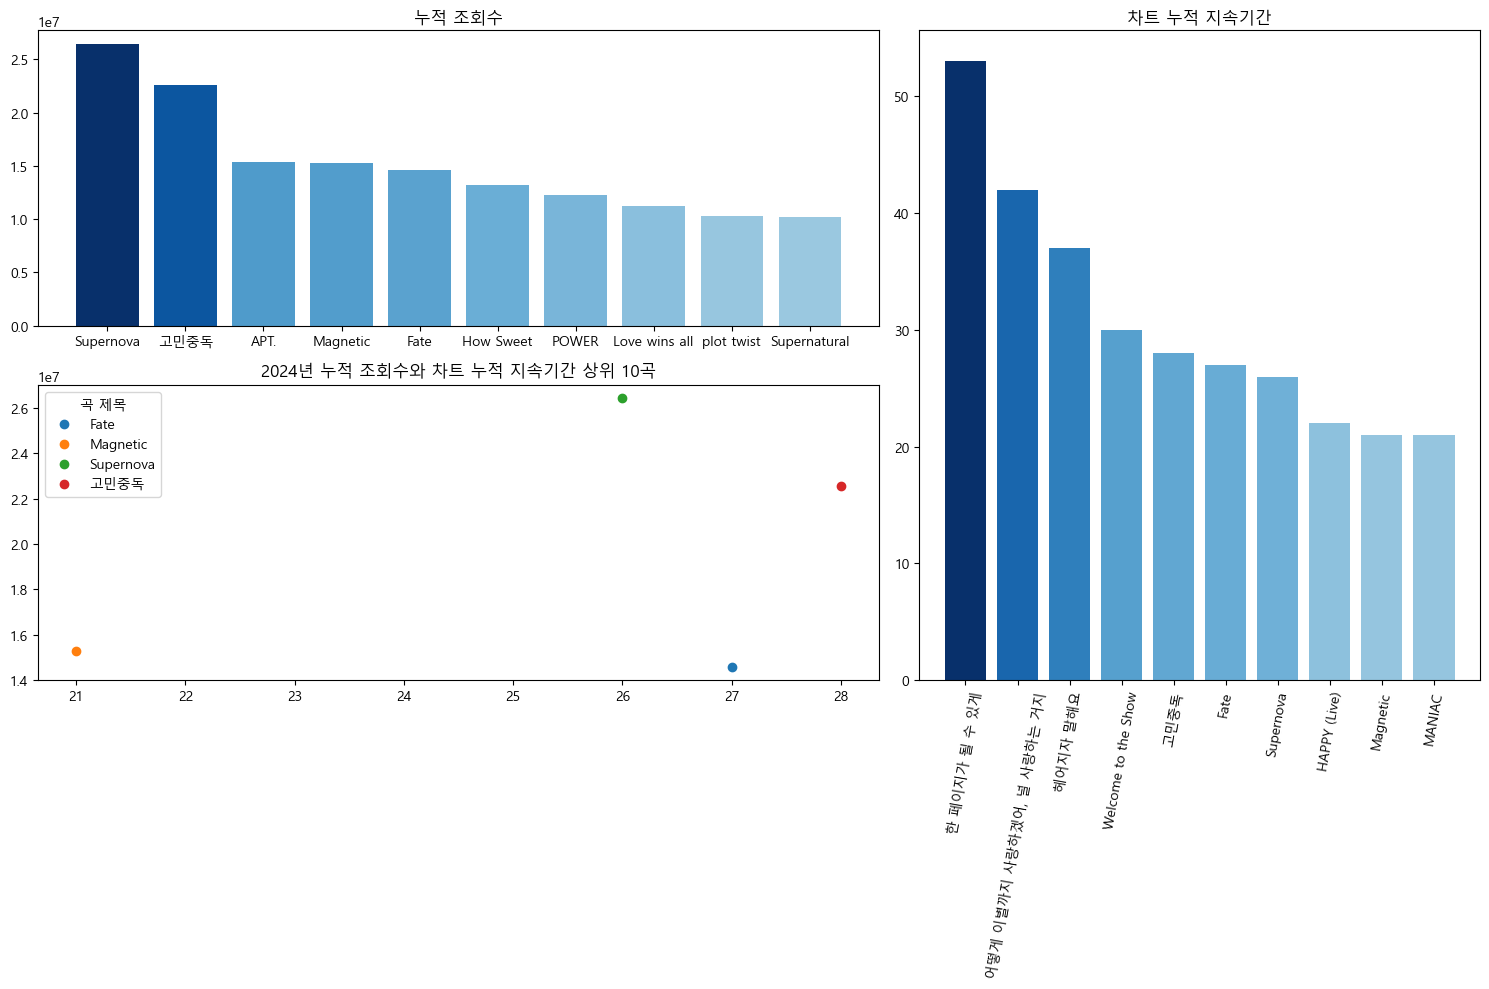

In [140]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(2, 2, width_ratios=[1.5, 1])

ax0 = plt.subplot(gs[0, 0])
# 조회수에 따라 alpha 값 계산 (numpy 사용)
alphas0 = np.array(bb['조회수']) / np.max(bb['조회수'])  # numpy 배열로 변환하여 계산
colors0 = plt.cm.Blues(alphas0)  # alpha 값에 맞는 색상 매핑
ax0.bar(list(bb.index), bb['조회수'], color=colors0)
ax0.set_title('누적 조회수')

ax1 = plt.subplot(gs[:, 1])
# 차트 지속기간에 따라 alpha 값 계산 (numpy 사용)
alphas1 = np.array(aa['차트 지속기간']) / np.max(aa['차트 지속기간'])  # numpy 배열로 변환하여 계산
colors1 = plt.cm.Blues(alphas1)  # alpha 값에 맞는 색상 매핑
ax1.bar(list(aa.index), aa['차트 지속기간'], color=colors1)
ax1.tick_params(axis='x', rotation=80)
ax1.set_title('차트 누적 지속기간')

ax2 = plt.subplot(gs[1, 0])
for idx in ccc.index:
    ax2.scatter(ccc.loc[idx, '차트 지속기간'], ccc.loc[idx, '조회수'], label=idx)
ax2.set_title('2024년 누적 조회수와 차트 누적 지속기간 상위 10곡')
ax2.legend(title='곡 제목', loc='best')

plt.tight_layout()
plt.show()

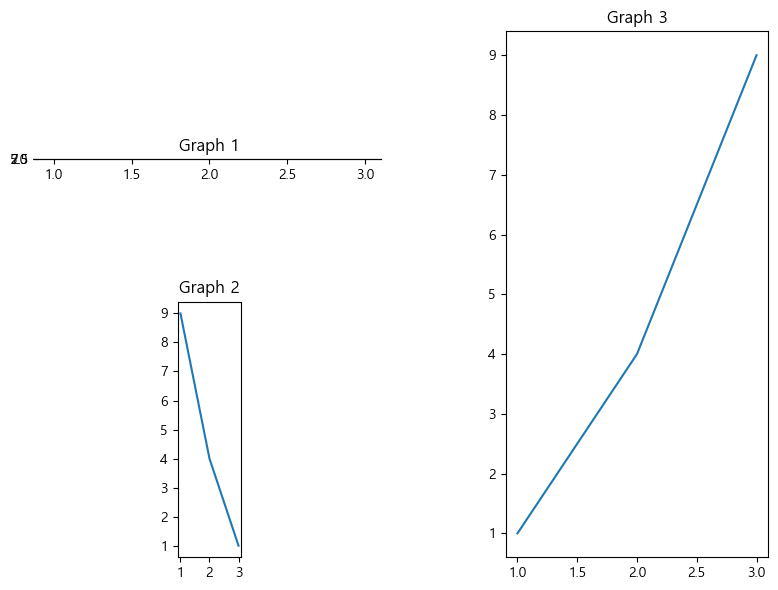

In [95]:
import matplotlib.pyplot as plt
from matplotlib import gridspec

# 그리드 설정 (2행 2열), (0, 1)과 (1, 1)에 하나의 그래프가 두 칸을 차지하도록 설정
fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 2])  # 두 번째 열의 크기를 두 배로 설정

# (0, 0) 그래프
ax0 = plt.subplot(gs[0, 0])
ax0.plot([1, 2, 3], [1, 4, 9], label='Graph 1')
ax0.set_title('Graph 1')

# (1, 0) 그래프
ax1 = plt.subplot(gs[1, 0])
ax1.plot([1, 2, 3], [9, 4, 1], label='Graph 2')
ax1.set_title('Graph 2')

# (0, 1)과 (1, 1) 하나의 그래프
ax2 = plt.subplot(gs[:, 1])  # 첫 번째와 두 번째 행을 차지하는 서브플롯
ax2.plot([1, 2, 3], [1, 4, 9], label='Graph 3')
ax2.set_title('Graph 3')

# 각 그래프의 크기 설정
ax0.set_aspect(0.00005)  # (0, 0) 그래프의 비율 설정
ax1.set_aspect(1)    # (1, 0) 그래프의 비율 설정
ax2.set_aspect(0.5)  # (0, 1)과 (1, 1) 그래프의 비율 설정

# 레이아웃 자동 조정
plt.tight_layout()

# 그래프 표시
plt.show()


---

In [301]:
df_month_artist = list(df_month.가수.value_counts().index)
df_month_song = list(df_month.가수.value_counts())

data = {
    '가수':df_month_artist,
    '노래':df_month_song
}

df_month_many = pd.DataFrame(data)
df_month_many

,가수,노래
0,aespa,16
1,NewJeans,12
2,QWER,10
3,(여자)아이들,8
4,르세라핌,8
5,DAY6(데이식스),7
6,아이유(IU),5
7,ILLIT,5
8,TWS (투어스),4
9,태연,4


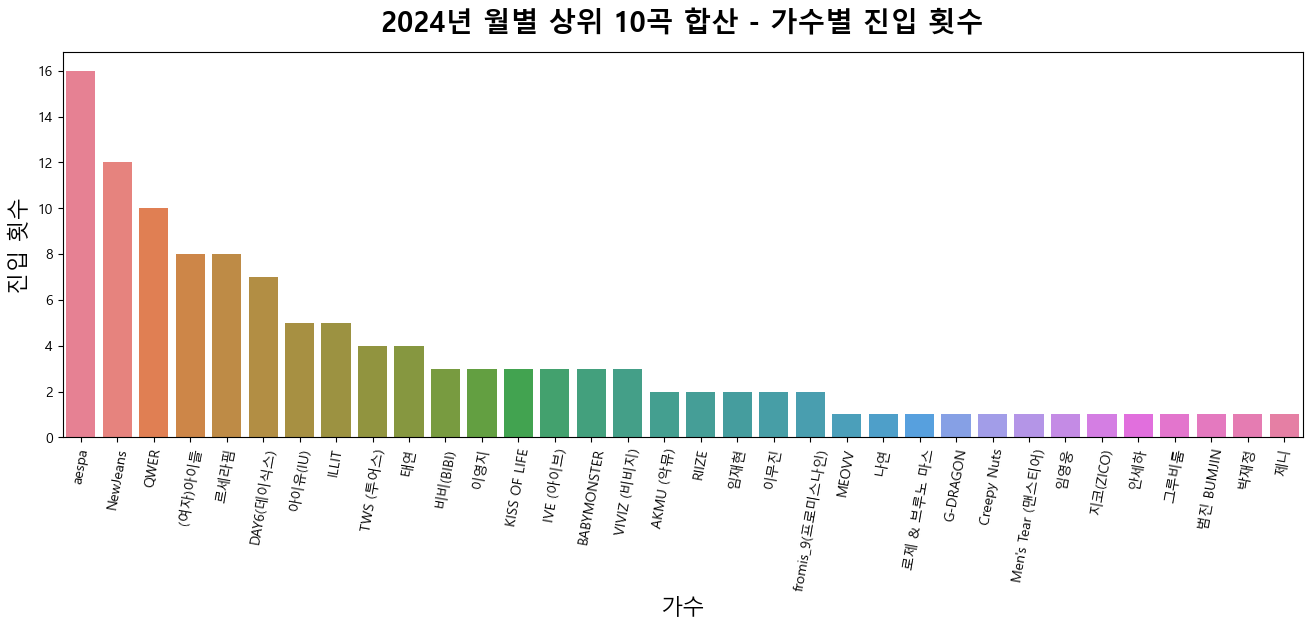

In [ ]:
plt.figure(figsize=(16,5))

cm = sns.color_palette('hls', len(df_month_many))

ax = sns.barplot(data=df_month_many, x='가수', y='노래', hue='가수', dodge=False)
ax.set_title('2024년 월별 상위 10곡 합산 - 가수별 차트 진입 횟수', pad=15, fontsize=20, fontweight='bold')
ax.set_xlabel("가수", fontsize=16)  # X축 제목 Bold
ax.set_ylabel("진입 횟수", fontsize=16)  # Y축 제목 Bold
ax.tick_params(axis='x', rotation=80)

plt.show()

In [377]:
aespa = df_month.query("가수 == 'aespa'").groupby('제목')[['주간 조회수']].sum()
aespa

,주간 조회수
제목,
Armageddon,9118383
Drama,9692428
Supernova,26417825
Whiplash,6477687


In [378]:
newjeans = df_month.query("가수 == 'NewJeans'").groupby('제목')[['주간 조회수']].sum()
newjeans

,주간 조회수
제목,
Bubble Gum,4250162
How Sweet,13255221
Right Now,2371207
Supernatural,10202791


In [379]:
qwer = df_month.query("가수 == 'QWER'").groupby('제목')[['주간 조회수']].sum()
qwer

,주간 조회수
제목,
고민중독,22562173
내 이름 맑음,8189596
디스코드,2571909


In [391]:
df_month3 = pd.concat([aespa, newjeans, qwer])
df_month3

,주간 조회수
제목,
Armageddon,9118383
Drama,9692428
Supernova,26417825
Whiplash,6477687
Bubble Gum,4250162
How Sweet,13255221
Right Now,2371207
Supernatural,10202791
고민중독,22562173


In [ ]:
# 주간 조회수 데이터
view_counts = [9118383, 9692428, 26417825, 6477687, 4250162, 
               13255221, 2371207, 10202791, 22562173, 8189596, 2571909]

# 최소값과 최대값 계산
min_val = min(view_counts)
max_val = max(view_counts)

# y축 범위 설정 (최소값에서 10% 아래, 최대값에서 10% 위)
plt.ylim(min_val * 0.9, max_val * 1.1)

In [412]:
max_val

26417825

In [ ]:
plt.figure(figsize=(16,5))
plt.bar(list(df_month3.index), df_month3['주간 조회수'])

max_val = df_month3['주간 조회수'].max()
plt.ylim(0, max_val * 1.1)
plt.yticks(range(0, int(max_val * 1.1)))

# y축 숫자 포맷을 일반 숫자 표기로 설정
plt.ticklabel_format(axis='y', style='plain')

plt.show()